# Product Recommendation Systems

## Data Description 
Data columns- First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.


## Source
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The
repository has several datasets. For this case study, we are using the Electronics
dataset.

## Learning Outcomes 
● Exploratory Data Analysis
● Data Wrangling
● Build a Popularity recommender model
● Build Collaborative Filtering model


## Objective
To make a recommendation system that recommends at least five(5)
new products based on the user's habits.

# Steps and tasks 


## 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics) 

### Import Libraries

In [9]:
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate

from collections import defaultdict


### Load CSV Data

In [2]:
original_df = pd.read_csv("ratings_Electronics.csv",names=['UserId','ProductId','Rating','Timestamp'])
original_df.head()

,UserId,ProductId,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
### Size of the data
original_df.shape

(7824482, 4)

In [5]:
### Fields info
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [123]:
### 5 point summary of distribution of Ratings
original_df['Rating'].value_counts().describe()

count    5.000000e+00
mean     1.564896e+06
std      1.603617e+06
min      4.563220e+05
25%      6.330730e+05
50%      9.017650e+05
75%      1.485781e+06
max      4.347541e+06
Name: Rating, dtype: float64

In [7]:
### Check any missing values
original_df.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [8]:
### Any nulls present
original_df.isnull().any()

UserId       False
ProductId    False
Rating       False
Timestamp    False
dtype: bool

In [9]:
### Unique User and Product counts
print("Overall Ratings Count = ",original_df.Rating.count())
print("Unique Users Count   :", len(np.unique(original_df.UserId)))
print("Unique Products Count  :", len(np.unique(original_df.ProductId)))

Overall Ratings Count =  7824482
Unique Users Count   : 4201696
Unique Products Count  : 476002


5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64


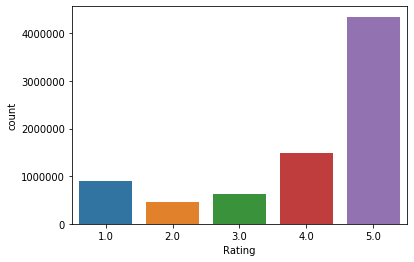

In [73]:
### Individual Ratings Overall Count & Check the distribution of different ratings with counts.
print(original_df['Rating'].value_counts().head())
sns.countplot(x='Rating',data=original_df)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: UserId, dtype: int64


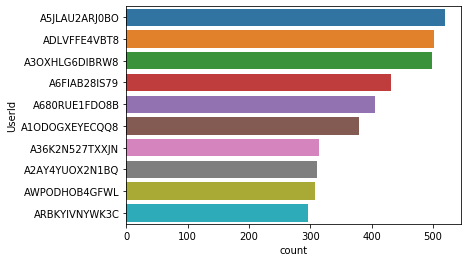

In [74]:
### Top 10 User Ids with maximum number of ratings given
print(original_df['UserId'].value_counts().head(10))
sns.countplot(y='UserId',data=original_df, order=original_df.UserId.value_counts().iloc[:10].index)

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: ProductId, dtype: int64


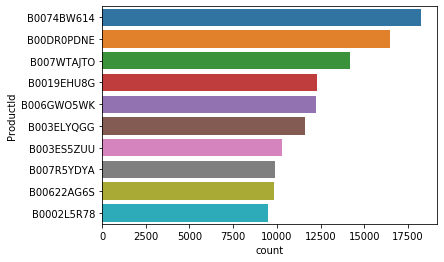

In [75]:
### Top 10 Product Ids with maximum number of ratings received
print(original_df['ProductId'].value_counts().head(10))
sns.countplot(y='ProductId',data=original_df, order=original_df.ProductId.value_counts().iloc[:10].index)

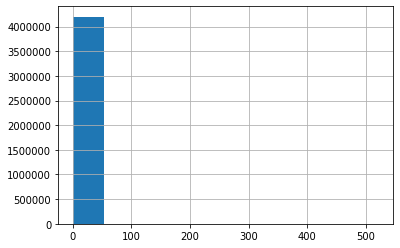

In [93]:
### Histogram of user counts for different number of ratings given
original_df['UserId'].value_counts().hist()

__Observation__: From the histogram we can observe that most of the data is with less than 50 ratings only.

In [101]:
### Lets check the data count of single user given ratings less than 50 
print("Single user given ratings less than 50 =  ",(original_df['UserId'].value_counts()[original_df['UserId'].value_counts()<50]).size)


Single user given ratings less than 50 =   4200156


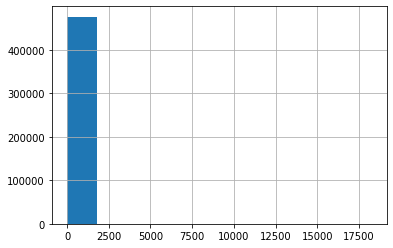

In [105]:
### Histogram of user counts for different number of ratings given
original_df['ProductId'].value_counts().hist()

__Observation__: From the histogram we can observe that most of the data is with less than 1550 ratings only.

In [102]:
### Lets check the data count of single product given ratings less than 1500 
print("Single product given ratings less than 1550 =  ",(original_df['ProductId'].value_counts()[original_df['ProductId'].value_counts()<1500]).size)


Single product given ratings less than 1550 =   475648


## 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) -

In [16]:
### Individual User's given review counts
original_df['UserId'].value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1D6X2HRKJELIA      1
AZ4BOBI1FYHFA       1
A3L82HQ57H1BSA      1
A3JLH3HD75B514      1
A3NUDBXK3S80C5      1
Name: UserId, Length: 4201696, dtype: int64

In [78]:
original_df['UserId'].value_counts()[original_df['UserId'].value_counts()==1]

A21FF4Y0QA78GA    1
A3V237DNOUGHGL    1
ALS730VAQT0WO     1
A2YUZON45ZV1JC    1
A2QV3Q8C1W4EX4    1
                 ..
A2P22DD9Q4SFXP    1
A22OK93WUNXFKC    1
A1ZEIY1EL9IBDG    1
AVW7DEBVGDQFC     1
A3MPBI1CMIY0UV    1
Name: UserId, Length: 2881832, dtype: int64

__Observation__:Most of the data of 2881832 users have rated one time in the website. 

In [3]:
### Trying to get the list of UserIds who has given rating more than 50 times
highrated_users_df = (original_df['UserId'].value_counts()[original_df['UserId'].value_counts()>50]).rename_axis('UserId').reset_index(name='RatingsCount')
print(highrated_users_df)

              UserId  RatingsCount
0      A5JLAU2ARJ0BO           520
1       ADLVFFE4VBT8           501
2     A3OXHLG6DIBRW8           498
3       A6FIAB28IS79           431
4      A680RUE1FDO8B           406
...              ...           ...
1461  A3QDMDSANPYGUX            51
1462   A57Q87B0TC9IJ            51
1463  A1SC5OXLQNGPLN            51
1464  A2LF07KCXDR70D            51
1465  A303SNZ4AR7TDQ            51

[1466 rows x 2 columns]


In [4]:
### List of UserIds we are going to consider for further proceedings
highrated_users_df['UserId']

0        A5JLAU2ARJ0BO
1         ADLVFFE4VBT8
2       A3OXHLG6DIBRW8
3         A6FIAB28IS79
4        A680RUE1FDO8B
             ...      
1461    A3QDMDSANPYGUX
1462     A57Q87B0TC9IJ
1463    A1SC5OXLQNGPLN
1464    A2LF07KCXDR70D
1465    A303SNZ4AR7TDQ
Name: UserId, Length: 1466, dtype: object

In [14]:
### Subset of the original dataframe by getting only the UserIds who has given ratings more than 50
filtered_df = original_df[original_df.UserId.isin(highrated_users_df['UserId'])]
print(filtered_df)

                 UserId   ProductId  Rating   Timestamp
118       AT09WGFUM934H  0594481813     3.0  1377907200
177      A32HSNCNPRUMTR  0970407998     1.0  1319673600
178      A17HMM1M7T9PJ1  0970407998     4.0  1281744000
492      A3CLWR1UUZT6TG  0972683275     5.0  1373587200
631      A3TAS1AG6FMBQW  0972683275     5.0  1353456000
...                 ...         ...     ...         ...
7824426   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0  1405641600
7824427  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0  1405209600
7824436  A3AYSYSLHU26U9  B00LI4ZZO8     4.0  1405296000
7824438  A2NYK9KWFMJV4Y  B00LI4ZZO8     5.0  1405209600
7824444  A2BYV7S1QP2YIG  B00LKG1MC8     5.0  1404950400

[122171 rows x 4 columns]


In [6]:
### After filtering Users who has given more than 50 rating the subset dataframe shape
filtered_df.shape

(122171, 4)

In [24]:
print(filtered_df)

                 UserId   ProductId  Rating   Timestamp
118       AT09WGFUM934H  0594481813     3.0  1377907200
177      A32HSNCNPRUMTR  0970407998     1.0  1319673600
178      A17HMM1M7T9PJ1  0970407998     4.0  1281744000
492      A3CLWR1UUZT6TG  0972683275     5.0  1373587200
631      A3TAS1AG6FMBQW  0972683275     5.0  1353456000
...                 ...         ...     ...         ...
7824426   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0  1405641600
7824427  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0  1405209600
7824436  A3AYSYSLHU26U9  B00LI4ZZO8     4.0  1405296000
7824438  A2NYK9KWFMJV4Y  B00LI4ZZO8     5.0  1405209600
7824444  A2BYV7S1QP2YIG  B00LKG1MC8     5.0  1404950400

[122171 rows x 4 columns]


In [25]:
filtered_df.shape

(122171, 4)

__Note__: The given dataset is a huge one with 7,824,482  rows. We need to create a subset of the original given data. For that I am going to use the logic to consider the Uesrs who has given more than 50 rating to different products.

So after applying this logic on original data set and filtering we got a dataset of 122171 rows. For further recommendatin system building we are going to use this data set only.

In [15]:
### As we don't need the timestamp data for this recommendation system we can drop that attribute
filtered_df.drop(columns='Timestamp',axis=1,inplace=True)

In [16]:
filtered_df.head()

,UserId,ProductId,Rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [28]:
### Unique User and Product counts
print("Overall Ratings Count = ",filtered_df.Rating.count())
print("Unique Users Count   :", len(np.unique(filtered_df.UserId)))
print("Unique Products Count  :", len(np.unique(filtered_df.ProductId)))

Overall Ratings Count =  122171
Unique Users Count   : 1466
Unique Products Count  : 47155


5.0    68872
4.0    31480
3.0    11747
2.0     5175
1.0     4897
Name: Rating, dtype: int64


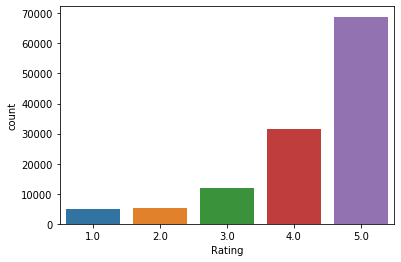

In [80]:
### Check the distribution of different ratings with counts after applying the filter
print(filtered_df['Rating'].value_counts().head())
sns.countplot(x='Rating',data=filtered_df)

In [30]:
### 5 point summary of distribution of Ratings
filtered_df['Rating'].value_counts().describe()

count        5.000000
mean     24434.200000
std      27101.408537
min       4897.000000
25%       5175.000000
50%      11747.000000
75%      31480.000000
max      68872.000000
Name: Rating, dtype: float64

In [33]:
### 5 point summary of distribution of UserId ratings count
filtered_df['UserId'].value_counts().describe()

count    1466.000000
mean       83.336289
std        46.930558
min        51.000000
25%        57.000000
50%        68.000000
75%        91.000000
max       520.000000
Name: UserId, dtype: float64

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: UserId, dtype: int64


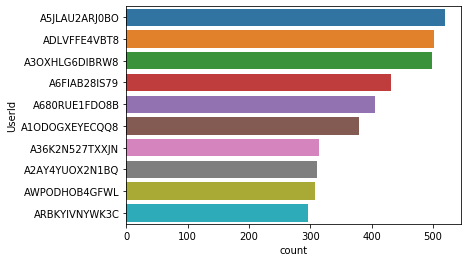

In [81]:
### Top 10 active User Ids with maximum number of ratings given
print(filtered_df['UserId'].value_counts().head(10))
sns.countplot(y='UserId',data=filtered_df, order=filtered_df.UserId.value_counts().iloc[:10].index)

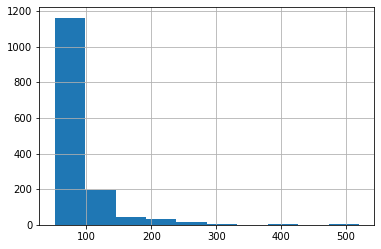

In [104]:
### Histogram of user counts for different number of ratings given
filtered_df['UserId'].value_counts().hist()

In [36]:
### 5 point summary of distribution of ProductId ratings count
filtered_df['ProductId'].value_counts().describe()

count    47155.000000
mean         2.590839
std          5.055156
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        204.000000
Name: ProductId, dtype: float64

B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
B008DWCRQW    135
B00829THK0    132
B002R5AM7C    127
B004CLYEDC    117
B004T9RR6I    108
Name: ProductId, dtype: int64


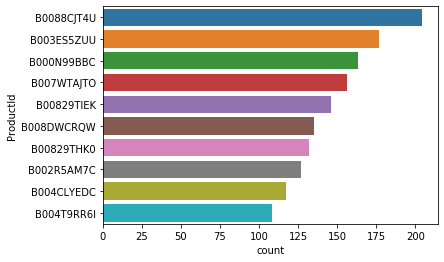

In [82]:
### Top 10 active Product Ids with maximum number of ratings given
print(filtered_df['ProductId'].value_counts().head(10))
sns.countplot(y='ProductId',data=filtered_df, order=filtered_df.ProductId.value_counts().iloc[:10].index)

## 3. Build Popularity Recommender model.

In [38]:
### Average rating of the individual ProductIds 
filtered_df.groupby('ProductId')['Rating'].mean().head()

ProductId
0594481813    3.0
0970407998    2.5
0972683275    5.0
1400501466    3.0
1400501520    5.0
Name: Rating, dtype: float64

In [39]:
### Average rating of the individual ProductId in descending order
filtered_df.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()

ProductId
B00LKG1MC8    5.0
B000H8WLKC    5.0
B000HA4EZK    5.0
B004EHZZDW    5.0
B004EI0EG4    5.0
Name: Rating, dtype: float64

In [127]:
### Total no of ratings count for individual ProductIds in descending order
filtered_df.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head(10)

ProductId
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
B008DWCRQW    135
B00829THK0    132
B002R5AM7C    127
B004CLYEDC    117
B004T9RR6I    108
Name: Rating, dtype: int64

In [41]:
ratings_mean_count = pd.DataFrame(filtered_df.groupby('ProductId')['Rating'].mean()) 

In [42]:
ratings_mean_count['Rating_Counts'] = pd.DataFrame(filtered_df.groupby('ProductId')['Rating'].count())  

In [43]:
ratings_mean_count.shape

(47155, 2)

In [129]:
### Top 5 ProductIds based on their ratings count with the mean ratings
ratings_mean_count.sort_values(by=['Rating_Counts'], ascending=False).head(5)

,Rating,Rating_Counts
ProductId,,
B0088CJT4U,4.215686,204
B003ES5ZUU,4.858757,177
B000N99BBC,4.773006,163
B007WTAJTO,4.692308,156
B00829TIEK,4.431507,146


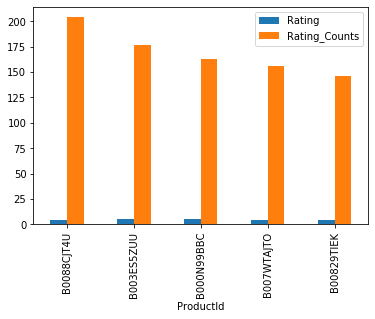

In [130]:
### Top 5 ProductIds based on their ratings count with the mean ratings
ratings_mean_count.sort_values(by=['Rating_Counts'], ascending=False).head(5).plot(kind = "bar")

## 4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio) 

In [17]:
### Reading the dataset
reader = Reader(rating_scale=(1, 5))
df = Dataset.load_from_df(filtered_df,reader)

In [21]:
### Splitting the dataset in 70/30 ratio
train_set, test_set = train_test_split(df, test_size=0.3,random_state=10)

In [107]:
### train_set.ur

## 5. Build Collaborative Filtering model.

In [56]:
### Let's build a pivot table to check the ratings between all the given users and the products
sub_filtered_df=filtered_df.head(10000)
ratings_matrix = filtered_df.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_matrix.head()

ProductId,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105S56ODHGJEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105TOJ6LTVMBG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10AFVU66A79Y1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
ratings_matrix.shape

(1466, 47155)

__Observation__: Seems lot of zeros means missing ratings between most of the users and the products.

In [58]:
### Density of the matrix
given_ratings = np.count_nonzero(ratings_matrix)
possible_ratings = ratings_matrix.shape[0]*ratings_matrix.shape[1]
given_ratings/possible_ratings

0.001767284258771579

__Observation__: Very sparce matrix and is inefficient. So we have to predict the ratings for zero valued ratings for different user product combinations using different collaborative algorithms.

### Memory Based Collaborative Filtering

#### KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [38]:
### Item-Item Collaborative Filtering Model
item_based_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
item_based_model.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [66]:
### User-User Collaborative Filtering Model
user_based_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
user_based_model.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [67]:
### Get a prediction rating for specific user and item.
pred = item_based_model.predict('A2RU4U1JZ3DMP5', 'B0002LEMWE', verbose=True)

user: A2RU4U1JZ3DMP5 item: B0002LEMWE r_ui = None   est = 4.93   {'actual_k': 0, 'was_impossible': False}


In [70]:
### Print actual rating and the model's predicted rating for each user and product combination just to view
i =0
for index, row in filtered_df.iterrows():
    i=i+1
    uid = row['UserId']
    iid = row['ProductId']
    rating = row['Rating']
    pre_rating = item_based_model.predict(uid, iid, verbose=False).est
    print("%d UserId = %s, ProductId = %s, ActualRating = %s, PredictedRating = %s" % (i,uid,iid,rating,pre_rating))
    if(i==10):
        break

1 UserId = AT09WGFUM934H, ProductId = 0594481813, ActualRating = 3.0, PredictedRating = 3.0
2 UserId = A32HSNCNPRUMTR, ProductId = 0970407998, ActualRating = 1.0, PredictedRating = 1
3 UserId = A17HMM1M7T9PJ1, ProductId = 0970407998, ActualRating = 4.0, PredictedRating = 1
4 UserId = A3CLWR1UUZT6TG, ProductId = 0972683275, ActualRating = 5.0, PredictedRating = 5
5 UserId = A3TAS1AG6FMBQW, ProductId = 0972683275, ActualRating = 5.0, PredictedRating = 5
6 UserId = A25RTRAPQAJBDJ, ProductId = 0972683275, ActualRating = 5.0, PredictedRating = 5
7 UserId = A3LDPF5FMB782Z, ProductId = 1400501466, ActualRating = 5.0, PredictedRating = 5
8 UserId = A1A5KUIIIHFF4U, ProductId = 1400501466, ActualRating = 1.0, PredictedRating = 1
9 UserId = A2XIOXRRYX0KZY, ProductId = 1400501466, ActualRating = 3.0, PredictedRating = 3.0
10 UserId = AW3LX47IHPFRL, ProductId = 1400501466, ActualRating = 5.0, PredictedRating = 5


### Model Based Collaborative Filtering

#### We are going to use SVD algorithm of surprise library which uses matrix factorization.

In [60]:
svd_model = SVD()
svd_model.fit(train_set)

## 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

### Memory Based Collaborative Filtering

In [69]:
### Run the trained Item-Item collaborative filtering model against the testset
item_item_pred = item_based_model.test(test_set)
item_item_pred[:10]

[Prediction(uid='AJL3U764D7NI3', iid='B0002LEMWE', r_ui=5.0, est=4.928571428571429, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2RU4U1JZ3DMP5', iid='B0031AQ302', r_ui=4.0, est=4.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A84FLVDK2R5JF', iid='B004N625AK', r_ui=5.0, est=4.2, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A32482Z7XIKDQX', iid='B00EBPNC78', r_ui=5.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3A4ZAIBQWKOZS', iid='B00067OEPO', r_ui=4.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3W4D8XOGLWUN5', iid='B004MPR0ZC', r_ui=4.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1E1LEVQ9VQNK', iid='B005OOKNP4', r_ui=5.0, est=4.612222686451331, details={'actual_k': 2, 'was_impossible': False}),
 Pr

In [53]:
### RMSE (Mean Absolute Error)
print("Item-Item Collaborative Filtering Model : Test Set")
accuracy.rmse(item_item_pred, verbose=True)

Item-Item Collaborative Filtering Model : Test Set
RMSE: 1.1394


1.1394480408142575

In [112]:
### MAE (Mean Absolute Error)
print("Item-Item Collaborative Filtering Model : Test Set")
accuracy.mae(item_item_pred, verbose=True)

Item-Item Collaborative Filtering Model : Test Set
MAE:  0.8083


0.8082733088591534

In [68]:
### Run the trained User-User collaborative filtering model against the testset
user_user_pred = user_based_model.test(test_set)
user_user_pred[:10]

[Prediction(uid='AJL3U764D7NI3', iid='B0002LEMWE', r_ui=5.0, est=4.711111111111111, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2RU4U1JZ3DMP5', iid='B0031AQ302', r_ui=4.0, est=4.190476190476191, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A84FLVDK2R5JF', iid='B004N625AK', r_ui=5.0, est=4.142857142857143, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A32482Z7XIKDQX', iid='B00EBPNC78', r_ui=5.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3A4ZAIBQWKOZS', iid='B00067OEPO', r_ui=4.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3W4D8XOGLWUN5', iid='B004MPR0ZC', r_ui=4.0, est=4.261181725698383, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1E1LEVQ9VQNK', iid='B005OOKNP4', r_ui=5.0, est=5, details={'actual_k': 4, 'was_impossible': F

In [55]:
### RMSE
print("User-User Collaborative Filtering Model : Test Set")
accuracy.rmse(user_user_pred, verbose=True)

User-User Collaborative Filtering Model : Test Set
RMSE: 1.0476


1.0476044141023797

In [113]:
### MAE (Mean Absolute Error)
print("Item-Item Collaborative Filtering Model : Test Set")
accuracy.mae(user_user_pred, verbose=True)

Item-Item Collaborative Filtering Model : Test Set
MAE:  0.7721


0.7721493550044846

In [41]:
### To inspect our predictions in details, we are going to build a pandas data frame with all the predictions. 

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:
        return 0

In [43]:
 
analysis_df = pd.DataFrame(item_item_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
analysis_df['Iu'] = analysis_df.uid.apply(get_Iu)
analysis_df['Ui'] = analysis_df.iid.apply(get_Ui)
analysis_df['err'] = abs(analysis_df.est - analysis_df.rui)
best_predictions = analysis_df.sort_values(by='err')[:10]
worst_predictions = analysis_df.sort_values(by='err')[-10:]

In [142]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
18325,A2NB2E5DXE319Z,B00IVPU6AA,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",109,8,0.0
16315,A1B0NL8UWAELI7,B005LJKEXS,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",42,2,0.0
16316,A3V7D0LH8L7BG0,B003CGMQ38,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",118,8,0.0
16339,A2HNH4PKE5DPSI,B001S2PK72,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",52,1,0.0
3737,A16QODENBJVUI1,B008R7EXCE,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",63,5,0.0
16351,A1Z7U9K6X3FEOU,B00008BO8M,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",52,1,0.0
16361,A1KSNK256G46GX,B000V1JUJU,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",36,1,0.0
3734,A274MXTX3DYLUV,B0007QQJWA,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",47,2,0.0
16370,A3S3VSXEFXBMRC,B000J1E2JU,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",56,1,0.0
16378,ADOR3TR7GDF68,B001TH7GUU,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",76,58,0.0


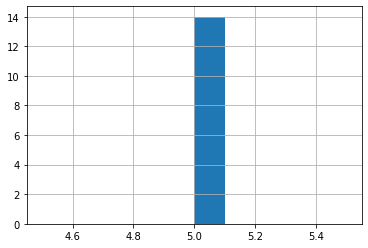

In [147]:
### We are going to plot histogram of the ratings for the product B00IVPU6AA to check why it has best prediction
filtered_df.loc[filtered_df['ProductId'] == 'B00IVPU6AA']['Rating'].hist()

__Observation__: As the ratings for this book are same from 14 different users the algorithm has got zero error in prediction. Similarly we can do this type of analysis for all the products why they got best score.
7

In [134]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6613,A1KD8NJPZ01R37,B000ML4RK6,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",65,1,4.0
7914,A2NX6MFZP8TM6S,B000BQ57BU,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",39,7,4.0
12453,A1ZU55TM45Y2R8,B001212ELY,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",124,4,4.0
12529,A11ULAZ4B5ZXC8,B0097JLRZM,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",41,1,4.0
12638,A1PM7HH4F77NEH,B000A6NUU6,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",45,1,4.0
20431,A2MOJANFPX353G,B0011E324K,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",32,1,4.0
12640,A2X06FP2PQ6EK0,B004M8SVDE,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",48,2,4.0
7832,A2TRXEZYU9GYY8,B002T0EK64,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",38,1,4.0
34863,A2503LT8PZIHAD,B001R4BTLC,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",78,5,4.0
34489,A3U41ZL33SS92P,B001SJVU6K,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",141,8,4.0


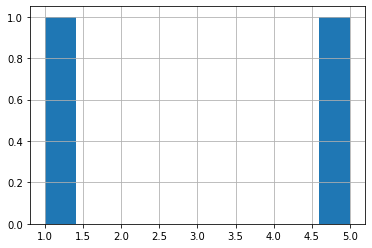

In [146]:
### We are going to plot histogram of the ratings for the product B000ML4RK6 to check why it has worst prediction
filtered_df.loc[filtered_df['ProductId'] == 'B000ML4RK6']['Rating'].hist()

__Observation__: As the ratings for this book are completely different from two users the algorithm has got hiegest error in prediction. Similarly we can do this type of analysis for all the products why they got worst score.

### Model Based Collaborative Filtering

In [61]:
svd_model_predictions = svd_model.test(test_set)

In [64]:
svd_model_predictions[:10]

[Prediction(uid='AJL3U764D7NI3', iid='B0002LEMWE', r_ui=5.0, est=4.955966094075813, details={'was_impossible': False}),
 Prediction(uid='A2RU4U1JZ3DMP5', iid='B0031AQ302', r_ui=4.0, est=4.144445767456589, details={'was_impossible': False}),
 Prediction(uid='A84FLVDK2R5JF', iid='B004N625AK', r_ui=5.0, est=4.211418465718255, details={'was_impossible': False}),
 Prediction(uid='A32482Z7XIKDQX', iid='B00EBPNC78', r_ui=5.0, est=4.456887111320788, details={'was_impossible': False}),
 Prediction(uid='A3A4ZAIBQWKOZS', iid='B00067OEPO', r_ui=4.0, est=4.528312268503909, details={'was_impossible': False}),
 Prediction(uid='A3W4D8XOGLWUN5', iid='B004MPR0ZC', r_ui=4.0, est=3.8157474830298743, details={'was_impossible': False}),
 Prediction(uid='A1E1LEVQ9VQNK', iid='B005OOKNP4', r_ui=5.0, est=4.740865740714807, details={'was_impossible': False}),
 Prediction(uid='A1UQBFCERIP7VJ', iid='B00834SJSK', r_ui=5.0, est=4.813648644902005, details={'was_impossible': False}),
 Prediction(uid='APBDZ88BBTN4F', i

In [52]:
### RMSE
print("SVD Collaborative Filtering Model : RMSE")
accuracy.rmse(svd_model_predictions, verbose=True)

SVD Collaborative Filtering Model : RMSE
RMSE: 0.9735


0.973474315542883

In [53]:
### MAE (Mean Absolute Error)
print("SVD Collaborative Filtering Model : MAE")
accuracy.mae(svd_model_predictions, verbose=True)

SVD Collaborative Filtering Model : MAE
MAE:  0.7292


0.7292445957782889

__Observation__: SVD has better RMSE value compare to both item-item and user-user collaborative filtering models. 

## 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [23]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Memory Based Collaborative Filtering

In [54]:
### Capture the top 5 products of each user from the evoluated predictions
K= 5
knn_top_n = get_top_n(item_item_pred, K)

In [62]:
# Print the recommended top 5 products for each user using KNNWithMeans algorithm
count = 0
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    count = count+1
    if(count==10):
        break

AJL3U764D7NI3 ['B0002LEMWE', 'B009HP42HQ', 'B000CKVOOY', 'B00AYQ433U', 'B00CDY0DSA']
A2RU4U1JZ3DMP5 ['B004UHYUZU', 'B001G70M6S', 'B00007E89K', 'B002C76W4C', 'B002MU1ZRS']
A84FLVDK2R5JF ['B001P05NBA', 'B001RQ1R8U', 'B00C4Q61Z6', 'B005KFONIU', 'B00486MH80']
A32482Z7XIKDQX ['B009W34X5O', 'B0030F2U82', 'B00GTGETFG', 'B009NHAEXE', 'B0015DYMVO']
A3A4ZAIBQWKOZS ['B00G5OAT88', 'B003UI62AG', 'B0081EAK34', 'B001CF60R4', 'B00JEVHZHC']
A3W4D8XOGLWUN5 ['B000HVVO98', 'B00001OWYM', 'B000BONJXU', 'B0002ZAILY', 'B0097BEF1S']
A1E1LEVQ9VQNK ['B00DDH4TYA', 'B00HZN1WXE', 'B009BEXSNW', 'B0018Z0PWY', 'B0082E9K7U']
A1UQBFCERIP7VJ ['B00F1CRTLK', 'B001C4VRZK', 'B00B8O6IIK', 'B00E1CZRHY', 'B00EQD5ZS4']
APBDZ88BBTN4F ['B004K1EOCA', 'B00IVPU59W', 'B009AZSYC2', 'B001OI2YNS', 'B007KZQM8W']
ACY9QYNDFLVBI ['B007B5RIYI', 'B004RFGALC', 'B001FO4QHI', 'B004Z0S6RU', 'B007G5NNOW']


In [91]:
### For example to get Top 5 recommendations for the user id A2RU4U1JZ3DMP5
knn_top_n['A2RU4U1JZ3DMP5']

[('B004UHYUZU', 5),
 ('B001G70M6S', 5),
 ('B00007E89K', 5),
 ('B002C76W4C', 5),
 ('B002MU1ZRS', 4.833333333333333)]

### Model Based Collaborative Filtering

In [56]:
### Capture the top 5 products of each user from the evoluated predictions
K= 5
svd_top_n = get_top_n(svd_model_predictions, K)

In [61]:
# Print the recommended top 5 products for each user
count=0
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    count = count+1
    if(count==10):
        break

AJL3U764D7NI3 ['B0002LEMWE', 'B000CKVOOY', 'B009HP42HQ', 'B00AYQ433U', 'B003PHJJV6']
A2RU4U1JZ3DMP5 ['B001TUYTZM', 'B0000BZL5A', 'B00007E89K', 'B000L47AHG', 'B002MU1ZRS']
A84FLVDK2R5JF ['B001P05NBA', 'B005KFONIU', 'B002TLTE6O', 'B003FST9EC', 'B000O8WE66']
A32482Z7XIKDQX ['B00GTGETFG', 'B009W34X5O', 'B009NHAEXE', 'B0030F2U82', 'B000PNGM18']
A3A4ZAIBQWKOZS ['B0000BZL1P', 'B003ES5ZUU', 'B00COF7DGS', 'B00IX2VGFA', 'B00GO4GMAI']
A3W4D8XOGLWUN5 ['B007WTAJTO', 'B00BOHNYTW', 'B001F7AHOG', 'B0097BEF1S', 'B0002ZAILY']
A1E1LEVQ9VQNK ['B0082E9K7U', 'B00E3FHXYO', 'B00D50UNRM', 'B002WE4HE2', 'B003ES5ZR8']
A1UQBFCERIP7VJ ['B004CLYEDC', 'B00G4UQ6U8', 'B00834SJSK', 'B00BB72WX4', 'B00BANM6HQ']
APBDZ88BBTN4F ['B00IVPU59W', 'B007KZQM8W', 'B004K1EOCA', 'B001OI2YNS', 'B00FNPD1OY']
ACY9QYNDFLVBI ['B000JMJWV2', 'B006EKIQYM', 'B001FO4QHI', 'B0093H8H8I', 'B004Z0S6RU']


In [90]:
### For example to get Top 5 recommendations for the user id A2RU4U1JZ3DMP5
svd_top_n['A2RU4U1JZ3DMP5']

[('B001TUYTZM', 4.528972292634269),
 ('B0000BZL5A', 4.481965461708522),
 ('B00007E89K', 4.434250587146046),
 ('B000L47AHG', 4.419144753240528),
 ('B002MU1ZRS', 4.3969027776345)]

## 8. Summarise your insights.

__Summary__:

<li>By using Popularity Based Recommendation we came to know the products which have the highest number of reviews with the mean user ratings. This is basically used for the items which are in trend right now. The problem with this recommendation system is, it is not personalized to individual users.
<li>Memory Based Collaborative Recommendation System with KNN model we can identify the like minded users or similar type of products. We have modeled both item-item and user-user based Collaborative Recommendation and calculated the RMSE and MAE for both. By using these models we can estimate the ratings of users or products which are empty in the user-item association matrix.
<li>With Model Based Collaborative Recommendation System using Singular Value Decomposition we can derive the N - number of recommendations to the users. This algorithm uses Matrix Factorization method.
<li>Finally we derived the recommendations to all the users with top 5 products using both KNNWithMeans and SVD algorithms.

<br><br><br><br><br><br>
### Lets check for other best algorithms from surprise library with best RMSE value

I borrowed this part from the internet which can identify the best Collaborative Filtering Model with best RMSE value.
Here we are going to compare the different algorithms of surprise library like SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

In [18]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, df, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.980215,0.477173,0.520666
SVDpp,0.982877,129.594592,5.678525
SVD,0.983814,7.167566,0.485331
KNNBaseline,1.042143,0.818071,1.808207
KNNWithMeans,1.065412,0.258663,1.556756
KNNWithZScore,1.066698,0.423331,1.680020
CoClustering,1.078788,11.086694,0.561999
SlopeOne,1.094166,104.264154,6.402761
KNNBasic,1.109367,0.182329,1.426666


__Observation__: From the above table we can see that BaselineOnly algorithm give best RMSE in less time compare to other algorithms. Lets try to predict the recommendations using this algorithm.

In [22]:
### Fit the data in BaselineOnly model
baseline_only_model = BaselineOnly()
baseline_only_model.fit(train_set)

Estimating biases using als...


In [25]:
### Calculate the predictions with test data set
baseline_only_predictions = baseline_only_model.test(test_set)

In [29]:
### RMSE (Mean Absolute Error)
print("BaselineOnly Collaborative Filtering Model : RMSE")
accuracy.rmse(baseline_only_predictions, verbose=True)

BaselineOnly Collaborative Filtering Model : RMSE
RMSE: 0.9735


0.973474315542883

In [30]:
### MAE (Mean Absolute Error)
print("BaselineOnly Collaborative Filtering Model : MAE")
accuracy.mae(baseline_only_predictions, verbose=True)

BaselineOnly Collaborative Filtering Model : MAE
MAE:  0.7292


0.7292445957782889

In [44]:
### Identify the best predictions and the worst predictions of this algorithm
baseline_analysis_df = pd.DataFrame(baseline_only_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
baseline_analysis_df['Iu'] = baseline_analysis_df.uid.apply(get_Iu)
baseline_analysis_df['Ui'] = baseline_analysis_df.iid.apply(get_Ui)
baseline_analysis_df['err'] = abs(baseline_analysis_df.est - baseline_analysis_df.rui)
best_predictions = baseline_analysis_df.sort_values(by='err')[:10]
worst_predictions = baseline_analysis_df.sort_values(by='err')[-10:]

In [46]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7038,A10O7THJ2O20AG,B006W8U2MU,5.0,5.0,{'was_impossible': False},56,33,0.0
3529,A10O7THJ2O20AG,B00017LSPI,5.0,5.0,{'was_impossible': False},56,31,0.0
16714,A328S9RN3U5M68,B00BLCVD9I,5.0,5.0,{'was_impossible': False},49,7,0.0
9819,A1JWSDDIH5Z7DV,B004YKXGIK,5.0,5.0,{'was_impossible': False},52,5,0.0
4547,A54SG05AV6S4H,B0007TOR08,5.0,5.0,{'was_impossible': False},55,4,0.0
3502,A3D0UM4ZD2CMAW,B001XURPQI,5.0,5.0,{'was_impossible': False},79,6,0.0
21262,A3PCEB9ND82AGE,B003ES5ZUU,5.0,5.0,{'was_impossible': False},55,117,0.0
9759,A2GKMXRLI7KLFP,B000JMJWV2,5.0,5.0,{'was_impossible': False},56,43,0.0
13071,A3HR0ZZOFKQ97N,B007WTAJTO,5.0,5.0,{'was_impossible': False},70,110,0.0
34820,A2HDTOF8222KN3,B003ES5ZUU,5.0,5.0,{'was_impossible': False},45,117,0.0


In [48]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
18360,ACQYIC13JXAOI,B00IVPU7DG,1.0,4.781046,{'was_impossible': False},64,12,3.781046
219,A25TQLMIAPI1T6,B00E98O7GC,1.0,4.784054,{'was_impossible': False},44,17,3.784054
17245,ABE5E8B3J7MKY,B0033AF5WW,1.0,4.785512,{'was_impossible': False},41,3,3.785512
2615,A1XXMNLOLKNO0I,B00817ZM70,1.0,4.800116,{'was_impossible': False},69,0,3.800116
30094,A1XXMNLOLKNO0I,B000FOIYPY,1.0,4.800116,{'was_impossible': False},69,0,3.800116
10194,A680RUE1FDO8B,B0015AARJI,1.0,4.803942,{'was_impossible': False},300,22,3.803942
36271,A25FL6VLD7S23S,B00IUICOF8,1.0,4.825677,{'was_impossible': False},79,9,3.825677
9088,AGR1V15L6FLMA,B007WTAJTO,1.0,4.827929,{'was_impossible': False},45,110,3.827929
205,A35KBAQ4VBNQ6L,B00BGGDVOO,1.0,4.869325,{'was_impossible': False},47,36,3.869325
9162,AZMY6E8B52L2T,B004G6002M,1.0,4.981524,{'was_impossible': False},136,39,3.981524


In [26]:
### Capture the top 5 products of each user from the evoluated predictions
K= 5
baseline_top_n = get_top_n(baseline_only_predictions, K)

In [59]:
# Print the recommended top 5 products for each user
count = 0
for uid, user_ratings in baseline_top_n.items():
    count =count+1
    print(uid, [iid for (iid, _) in user_ratings])
    if(count==10):
        break

AJL3U764D7NI3 ['B0002LEMWE', 'B000CKVOOY', 'B009HP42HQ', 'B00AYQ433U', 'B003PHJJV6']
A2RU4U1JZ3DMP5 ['B001TUYTZM', 'B0000BZL5A', 'B00007E89K', 'B000L47AHG', 'B002MU1ZRS']
A84FLVDK2R5JF ['B001P05NBA', 'B005KFONIU', 'B002TLTE6O', 'B003FST9EC', 'B000O8WE66']
A32482Z7XIKDQX ['B00GTGETFG', 'B009W34X5O', 'B009NHAEXE', 'B0030F2U82', 'B000PNGM18']
A3A4ZAIBQWKOZS ['B0000BZL1P', 'B003ES5ZUU', 'B00COF7DGS', 'B00IX2VGFA', 'B00GO4GMAI']
A3W4D8XOGLWUN5 ['B007WTAJTO', 'B00BOHNYTW', 'B001F7AHOG', 'B0097BEF1S', 'B0002ZAILY']
A1E1LEVQ9VQNK ['B0082E9K7U', 'B00E3FHXYO', 'B00D50UNRM', 'B002WE4HE2', 'B003ES5ZR8']
A1UQBFCERIP7VJ ['B004CLYEDC', 'B00G4UQ6U8', 'B00834SJSK', 'B00BB72WX4', 'B00BANM6HQ']
APBDZ88BBTN4F ['B00IVPU59W', 'B007KZQM8W', 'B004K1EOCA', 'B001OI2YNS', 'B00FNPD1OY']
ACY9QYNDFLVBI ['B000JMJWV2', 'B006EKIQYM', 'B001FO4QHI', 'B0093H8H8I', 'B004Z0S6RU']


In [92]:
### For example to get Top 5 recommendations for the user id A2RU4U1JZ3DMP5
baseline_top_n['A2RU4U1JZ3DMP5']

[('B001TUYTZM', 4.528972292634269),
 ('B0000BZL5A', 4.481965461708522),
 ('B00007E89K', 4.434250587146046),
 ('B000L47AHG', 4.419144753240528),
 ('B002MU1ZRS', 4.3969027776345)]